# Comparison of reference plasmids and chromosomes

This notebook contains a simple check to see whether the reference plasmids and chromosomes share (longer) subsequences that could also imply (longer) shared paths in the associated assembly graph. Such merges could hamper the predictions due to the risk of introducing translocations.

*Summary:*   
The length of individual shared paths between reference plasmids and chromosomes (longest QUAST alignments) was usually short, especially on our test samples.
Therefore, we would consider merged paths less of an issue in our evaluation.

In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import statistics as st
from subprocess import call

pd.options.display.max_rows = None

load_modules = 'module load gcc/5.4.0 blast+/2.6.0 boost/1.60.0 perl/5.22.4 java/1.8.0_121 python/3.5.4; source $HOME/py3.5.4/bin/activate;'
unload_modules = 'deactivate; module unload python/3.5.4 java/1.8.0_121 perl/5.22.4 boost/1.60.0 blast+/2.6.0 gcc/5.4.0;'

# map plasmids against chromosomes, store the report.tsv file of QUAST and archive the created files
def evaluate(samples, sid, out_dir, reports_dir, archives_dir):
    sample_dir = '%s/sample_%i' % (out_dir, sid)
    references_fasta = '%s/chromosomes.fasta' % sample_dir
    queries_fasta = '%s/plasmids.fasta' % sample_dir

    call('mkdir -p %s' % sample_dir, shell = True)

    chrs = samples.at[sid, 'Chromosome'].split(',')
    plas = samples.at[sid, 'Plasmids'].split(',')

    for cid in chrs:
        call('curl -s "https://eutils.be-md.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id=%s&rettype=fasta&retmode=text" >> %s' % (cid, references_fasta), shell = True)

    for pid in plas:
        call('curl -s "https://eutils.be-md.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=nucleotide&id=%s&rettype=fasta&retmode=text" >> %s' % (pid, queries_fasta), shell = True)

    call(load_modules \
         + 'quast.py -o %s/quast -a all -m 0 -l plasmids -R %s %s; ' % (sample_dir, references_fasta, queries_fasta) \
         + unload_modules, shell = True)
          
    call('cp %s/quast/report.tsv %s/sample_%s.tsv' % (sample_dir, reports_dir, sid), shell = True)
    call('tar zcf %s/sample_%s.tar.gz %s; rm -r %s' % (archives_dir, sid, sample_dir, sample_dir), shell = True)
    
# create plots to visualise and compare the values in one column between all samples and only the test samples
def create_plot(df_all, df_test, col):
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10))
    
    c = '#2728d6', 
    axes[0][0].hist(df_all[col])
    axes[0][0].set_xlabel(col)
    axes[0][0].set_ylabel('count')
    
    axes[0][1].scatter(df_all['sample_id'], df_all[col], s = 10)
    axes[0][1].set_xlabel('sample_id')
    axes[0][1].set_ylabel(col)
    
    axes[0][2].violinplot(df_all[col], showextrema = False)
    axes[0][2].scatter([1 + random.uniform(-0.2, 0.2) for d in df_all[col]], df_all[col], alpha = 0.5, s = 10)
    axes[0][2].set_ylabel(col)
    axes[0][2].set_xticks([])

    
    c = '#d62728'
    axes[1][0].hist(df_test[col], color = c)
    axes[1][0].set_xlabel(col)
    axes[1][0].set_ylabel('count')
    
    axes[1][1].scatter(df_test['sample_id'], df_test[col], s = 10, color = c)
    axes[1][1].set_xlabel('sample_id')
    axes[1][1].set_ylabel(col)
    
    parts = axes[1][2].violinplot(df_test[col], showextrema = False)
    parts['bodies'][0].set_facecolor(c)
    parts['bodies'][0].set_alpha(0.3)
    axes[1][2].scatter([1 + random.uniform(-0.2, 0.2) for d in df_test[col]], df_test[col], alpha = 0.5, s = 10, facecolor = c)
    axes[1][2].set_ylabel(col)
    axes[1][2].set_xticks([])
    
# create a table of basic statistics on one column for both all samples and only the test samples
def create_table(df_all, df_test, col):
    contents = []
    
    row = ['all', df_all[col].min(), df_all[col].quantile(0.25), df_all[col].mean(), df_all[col].std(), df_all[col].quantile(0.5), df_all[col].quantile(0.75), df_all[col].max()]
    contents.append(row)
    
    row = ['test', df_test[col].min(), df_test[col].quantile(0.25), df_test[col].mean(), df_test[col].std(), df_test[col].quantile(0.5), df_test[col].quantile(0.75), df_test[col].max()]
    contents.append(row)
    
    return pd.DataFrame(contents, columns = ['set', 'min', 'Q1', 'mean', 'sd', 'median', 'Q3', 'max'])


For each sample, map the plasmid(s) against the chromosome(s) using QUAST.

In [3]:
out_dir = 'quast_alignments'
samples_file = '/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-05-23__MOB-suite_benchmark_reads/samples.csv'
all_ids = range(1, 134)
test_ids = [1,5,15,16,18,19,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,52,55,56,62,63,64,65,66,76,85,86,87,102,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,129,133]



reports_dir = '%s/reports' % out_dir
archives_dir = '%s/archives' % out_dir
call('mkdir -p %s %s %s' % (out_dir, reports_dir, archives_dir), shell = True)

samples_table = pd.read_csv(samples_file, sep = ';', dtype = str, index_col = 'SampleId')
  
for sid in all_ids:
    evaluate(samples_table, sid, out_dir, reports_dir, archives_dir)

Collect the relevant information from the report files.

In [4]:
contents = []

for sid in all_ids:
    report = pd.read_csv('%s/sample_%s.tsv' % (reports_dir, sid), sep = '\t', dtype = str, index_col = 'Assembly')
    
    row = []
    row.append(sid)
    row.append(float(report.at['Genome fraction (%)', 'plasmids']) if 'Genome fraction (%)' in report.index else 0.0)
    row.append(int(report.at['Largest alignment', 'plasmids']) if 'Largest alignment' in report.index else 0)
    row.append(int(report.at['Reference length', 'plasmids']))
    row.append(int(report.at['Total length', 'plasmids']))
    row.append(int(report.at['Unaligned length', 'plasmids']))
    row.append(int(report.at['# contigs', 'plasmids']))
    row.append(report.at['# unaligned contigs', 'plasmids'])
    
    contents.append(row)
    
all_stats = pd.DataFrame(contents, columns = ['sample_id', 'genome_fraction', 'largest_alignment', 'chr_length', 
                                              'pla_length', 'pla_unaligned_length', 'num_plasmids', 'unaligned_plasmids'])
test_stats = all_stats.loc[all_stats['sample_id'].isin(test_ids)]

*All samples*

In [5]:
all_stats

,sample_id,genome_fraction,largest_alignment,chr_length,pla_length,pla_unaligned_length,num_plasmids,unaligned_plasmids
0,1,0.000,0,4756751,198307,198307,1,1 + 0 part
1,2,0.624,7945,5099034,272297,239820,1,0 + 1 part
2,3,0.320,1331,4976908,512489,503130,9,6 + 3 part
3,4,0.363,3666,5029496,361153,345018,6,3 + 3 part
4,5,0.037,1817,4919453,115736,113919,1,0 + 1 part
5,6,1.023,4361,4753402,278050,254438,6,2 + 4 part
6,7,1.570,47676,4852980,649705,560252,3,1 + 2 part
7,8,0.212,5097,4633407,427981,413031,4,2 + 2 part
8,9,0.266,2623,4621385,338503,331911,3,1 + 2 part
9,10,0.141,1339,4879702,127285,121443,3,2 + 1 part


*Test samples*

In [6]:
test_stats

,sample_id,genome_fraction,largest_alignment,chr_length,pla_length,pla_unaligned_length,num_plasmids,unaligned_plasmids
0,1,0.000,0,4756751,198307,198307,1,1 + 0 part
4,5,0.037,1817,4919453,115736,113919,1,0 + 1 part
14,15,4.311,3440,2966909,430944,360632,2,0 + 2 part
15,16,1.454,1796,2598959,279233,258533,3,0 + 3 part
17,18,1.615,3582,5116580,303199,254635,3,0 + 3 part
18,19,0.003,137,4948797,208131,207994,3,2 + 1 part
22,23,0.630,785,4888773,37362,35807,1,0 + 1 part
23,24,0.344,1343,4920828,458871,446275,6,3 + 3 part
24,25,0.184,1445,5117319,177752,170356,2,0 + 2 part
25,26,0.155,1445,5042704,116529,110216,1,0 + 1 part


**Genome fraction**

QUAST defines 'Genome fraction (%)' as "the percentage of aligned bases in the reference genome. A base in the reference genome is aligned if there is at least one contig with at least one alignment to this base." (http://quast.bioinf.spbau.ru/manual.html#sec3.1).

In [7]:
create_table(all_stats, test_stats, 'genome_fraction')

,set,min,Q1,mean,sd,median,Q3,max
0,all,0.0,0.003,0.431293,0.563271,0.247,0.630,4.311
1,test,0.0,0.000,0.446258,0.683804,0.244,0.521,4.311


On average less than 0.5 % and at most 4.3 % of a chromosome is covered by the plasmids of the same sample.
However, this statistic is meaningful (than initially thought) because the chromosomes are, in general, much larger.

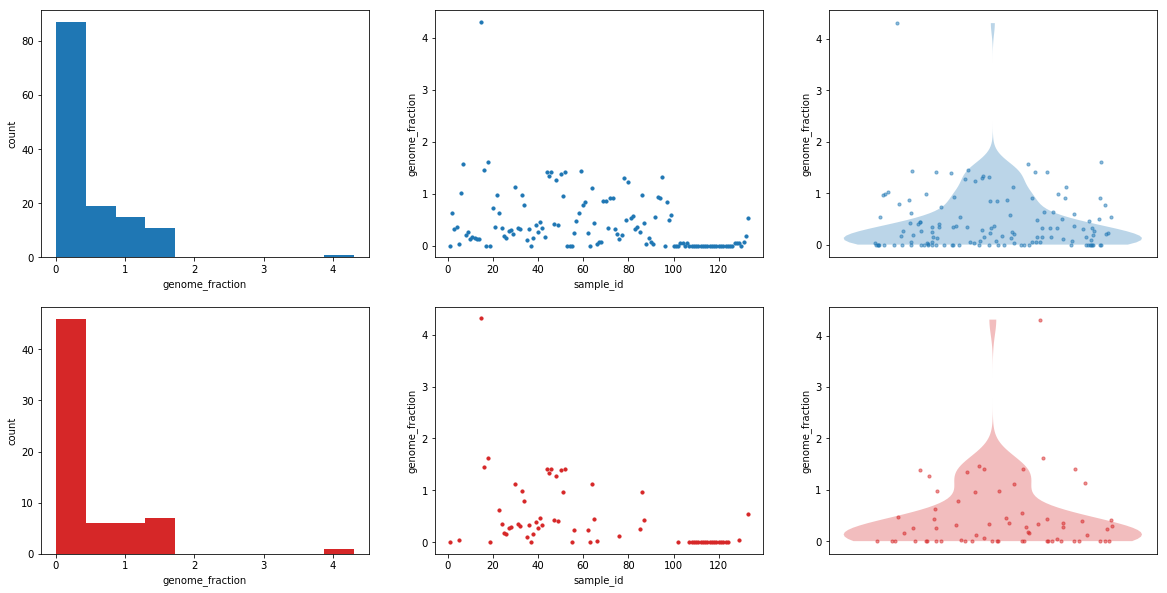

In [8]:
create_plot(all_stats, test_stats, 'genome_fraction') # top / blue = all samples; bottom / red = test samples

**Length of largest alignment between plamids and references per sample**

Per sample, we look at the length of the largest alignment between the plasmids and the chromosome.

In [9]:
create_table(all_stats, test_stats, 'largest_alignment')

,set,min,Q1,mean,sd,median,Q3,max
0,all,0,137.0,3238.789474,5150.219210,2015.0,3582.00,47676
1,test,0,0.0,1841.212121,2421.541642,1400.5,2531.25,15287


In our test samples, even the largest alignments are usually rather short (with a mean and median below 2000 nt). Even the third quartile is quite low (2531 nt). However, the maximum of 15287 nt shows that there are plasmid-chromosome pairs with much longer shared subsequences. 
There have to be even more extreme pairs in the non-test samples as all statistics are notably higher when considering all samples.

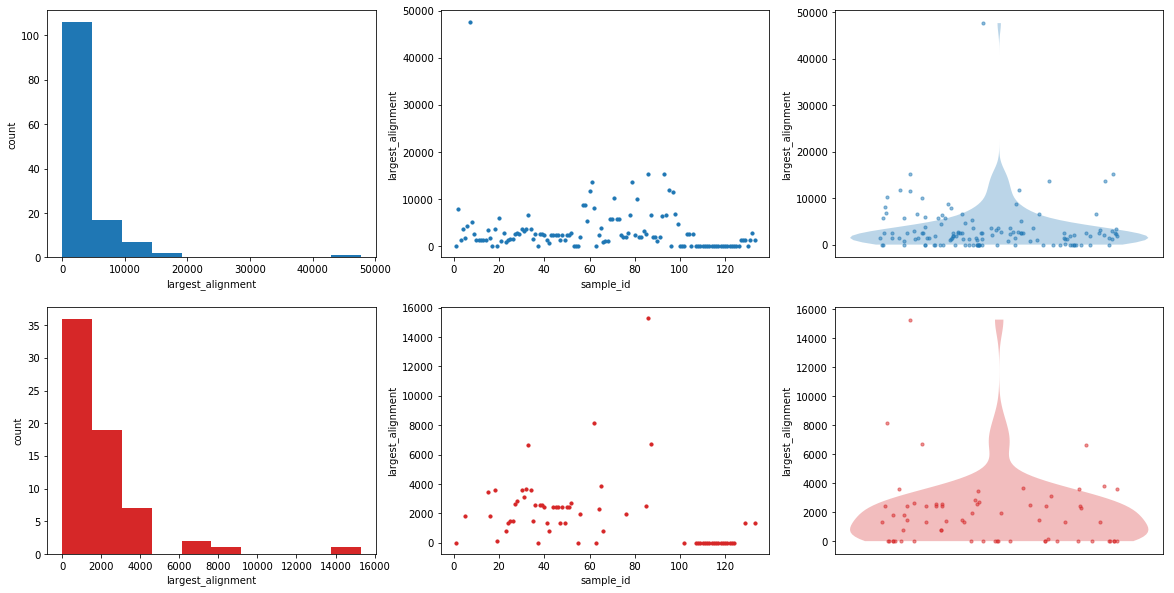

In [10]:
create_plot(all_stats, test_stats, 'largest_alignment') # top / blue = all samples; bottom / red = test samples

**Length of largest alignment vs average plasmid length**

Per sample, we look at the length of the largest alignment between the plasmids and the chromosome and divide that length by the mean length of the sample's plasmids.

In [11]:
all_fractions = pd.DataFrame([[row['sample_id'], row['largest_alignment'] / (row['pla_length'] / row['num_plasmids'])] for index, row in all_stats.iterrows()], columns = ['sample_id', 'fraction'])
test_fractions = pd.DataFrame([[row['sample_id'], row['largest_alignment'] / (row['pla_length'] / row['num_plasmids'])] for index, row in test_stats.iterrows()], columns = ['sample_id', 'fraction'])

In [12]:
create_table(all_fractions, test_fractions, 'fraction')

,set,min,Q1,mean,sd,median,Q3,max
0,all,0.0,0.001975,0.035735,0.066331,0.021586,0.042080,0.654682
1,test,0.0,0.000000,0.018635,0.026073,0.015222,0.026381,0.159477


By relating the length of the largest alignment to the mean length of the plasmids, we see that usually only short subsequences of the plasmids are shared with the chromosome. On average, a shared path has a length less than 2 % of the length of the plasmid (on the test samples). Again, the third quartile is not much higher but a maximum of almost 16 % over the test samples (and 65 % over all samples) shows that their can be long shared subsequences (even though they are rare).

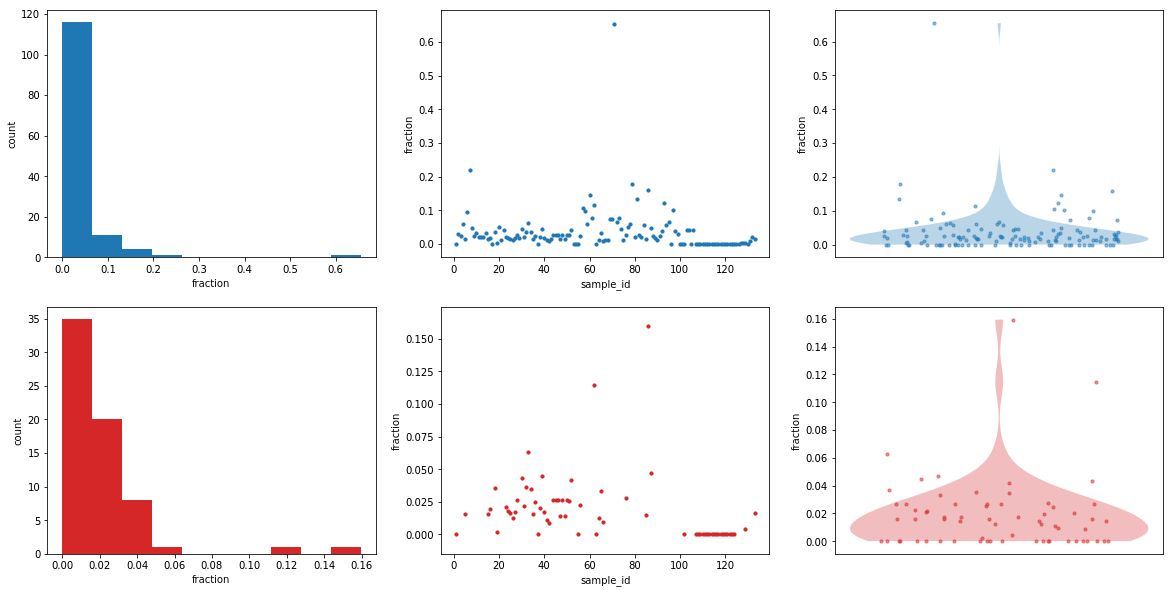

In [13]:
create_plot(all_fractions, test_fractions, 'fraction') # top / blue = all samples; bottom / red = test samples

The violin plots with the overlayed scatter plots show even better how rare the very long shared paths are: only 4 values above 6 % on the test samples and the second highest proportion over all samples is already down to slightly more than 20 %.

Considering that even the largest alignments are usually short (especially on our test samples), we would consider merged paths less of an issue in our evaluation.